In [85]:
import os
import pandas as pd
import numpy as np
from dynaconf import LazySettings
from dynaconf.utils.boxing import DynaBox
import sklearn
import sklearn.model_selection
import sklearn.ensemble
import matplotlib.pyplot as plt
from typing import Tuple
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout

In [86]:
config_file = "C://workspaces//learning//fantasAi_football//config//conf.yaml"
config_mode = 'default'

In [87]:
params = LazySettings(settings_files=[config_file])
params = params[config_mode]

In [88]:
def filter_dataset(params: DynaBox, y_feature: str, dataset: pd.DataFrame) -> pd.DataFrame: 
    """Filter a dataset on the basis of the input parameters.
    
    Only a subset of data supports the learning of specific "y" features.

    Args:
        params (DynaBox): run parameters
        y_feature (str): the feature to learn
        dataset (pd.DataFrame): the dataset to filter

    Returns:
        pd.DataFrame: _description_
    """
    if y_feature in [
        params["FEATURES"]["AVG_VOTE"],
        params["FEATURES"]["FANTA_POINTS_RATIO"],
    ]:

        if params["FEATURES"]["AVG_VOTE"] in y_feature:
            dataset = dataset.loc[dataset[params["FEATURES"]["AVG_VOTE"]].notna()]
        elif params["FEATURES"]["FANTA_POINTS_RATIO"] in y_feature:
            dataset = dataset.loc[
                dataset[params["FEATURES"]["COMPETITION"]].isin(
                    params["SETTINGS"]["TRAINING_COMPETITIONS"]
                )
            ]
            # Defenders are not judged by their ability to score
            dataset = dataset.loc[
                dataset[params["FEATURES"]["POSITION_INDEX"]]
                >= params["SETTINGS"]["MIN_POS_IX_SCORE"]
            ]
            # To judge ability to score he must have played a minimum number 
            # of matches
            dataset = dataset.loc[
                dataset[params["FEATURES"]["MINUTES_PLAYED"]]
                > params["SETTINGS"]["MIN_MATCHES_SCORE"]
                * params["SETTINGS"]["MINUTES_PER_GAME"]
            ]
        elif y_feature == params["FEATURES"]["ON_FIELD_INDEX"]:
            dataset = dataset.loc[
                dataset[params["FEATURES"]["COMPETITION"]].isin(
                    params["SETTINGS"]["TRAINING_COMPETITIONS"]
                )
            ]

    print(f"Dataset size: {len(dataset)}")

    return dataset

In [89]:
def plot_scatter(cfs, df, y_feature, name="Feature plot"):
    """
    Function to plot a scatter matrix of dataset of features.
    
    Example of use:
    
    >>> plot_scatter(['DL', 'DS', 'DP', 'AD', 'DE', 'LD', 'FS'], df)
    
    :param df: pd.DataFrame
        dataframe with the data to plot
    :param cfs: list
        list of the names of the columns to plot
    :param y_feature: (default: params["FEATURES"]["FANTA_POINTS_RATIO"])
        the feature to predict
    :param name: str
        name of the file where scatter matrix will be saved
    """
    X = df[cfs]
    y = df[y_feature]
    scatter = pd.plotting.scatter_matrix(
        X,
        c=y,
        marker='o',
        s=40,
        hist_kwds={'bins':15},
        figsize=(20,20)
    )
    plt.suptitle('Scatter-matrix for each input variable')
    plt.savefig(name)

In [90]:
# Transfermarkt dataset
data_path = os.path.join(
    params["PATHS"]["ROOT_FOLDER"],
    f"{params['PATHS']['STAGES']['MATCHED_DATASET']}.pkl",
)
complete_dataset = pd.read_pickle(data_path)

Define the causal factors and the y feature

In [91]:
def setup_causal_factors(dataset, y_feature, add_pred_features):

    foot_features = params["FEATURES"]["FOOT"]
    foot_dummy_features = [
        c for c in complete_dataset.columns if c.startswith(f"{foot_features}_")
    ]
    side_dummy_features = [
        c for c in complete_dataset.columns if c.startswith(f"side_")
    ]
    cfs = [
            params["FEATURES"]["MARKET_VALUE_RATIO"],
            params["FEATURES"]["CLUB_VALUE_RATIO"],
            params["FEATURES"]["POSITION_INDEX"],
    ]
    if y_feature == params["FEATURES"]["ON_FIELD_INDEX"]:
        cfs = cfs + [
                params["FEATURES"]["MARKET_REPL_NARROW"],
                params["FEATURES"]["MARKET_REPL_WIDE"],
            ]
        
    else:
        cfs = cfs + foot_dummy_features + side_dummy_features

    if add_pred_features:
        # Add existing predicted features
        for y_feature in [
            params["FEATURES"]["FANTA_POINTS_RATIO"],
            params["FEATURES"]["ON_FIELD_INDEX"],
            params["FEATURES"]["AVG_VOTE"],
        ]:
            y_pred_feature = f"{y_feature}_PRED_ANS"
            if y_pred_feature in dataset.columns:
                cfs.append(y_pred_feature)        

    return cfs

In [92]:
def train_rf(X_train, y_train, X_test, y_test, y_scaler, y_feature):
    # HINT: tried different parameters set (criterion, bootstrap off, max_depthint), with worse results.
    rf = sklearn.ensemble.RandomForestRegressor(random_state=0, bootstrap=True)
    rf.fit(X_train, y_train)
    print(f"RF: score on training set: {rf.score(X_train, y_train):.3f}")
    print(f"RF: score of on test set: {rf.score(X_test, y_test):.3f}")
    # yhat_rf=rf.predict(X_test)

    plot_test_regression(rf, y_scaler, X_test, y_test, f"RF - {y_feature}")

    return rf


def plot_nn_loss(history, y_feature):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    _, ax1 = plt.subplots()
    ax1.plot(loss, label="Loss")
    ax1.plot(val_loss, label="Validation Loss")
    ax1.legend()
    ax1.set_title(f"Neural Net Loss - {y_feature}")


def train_nn(cfs, X_train, y_train, X_test, y_test, y_scaler, y_feature):
    model = Sequential()
    model.add(
        Dense(len(cfs) * 4, kernel_initializer="normal", activation="relu")
    )
    # model.add(Dropout(0.2))
    model.add(
        Dense(len(cfs) * 4, kernel_initializer="normal", activation="relu")
    )
    # model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer="normal", activation="linear"))

    es = EarlyStopping(
        monitor="val_loss",
        mode="min",
        verbose=1,
        min_delta=0.0001,
        patience=20,
        restore_best_weights=True,
    )

    model.compile(loss=MeanSquaredLogarithmicError(), optimizer="adam")

    # HINT: tried with different epochs and batch_size, worse results
    X_train = np.asarray(X_train).astype("float32")
    y_train = np.asarray(y_train).astype("float32")
    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=100,
        validation_split=0.2,
        callbacks=[es],
        verbose=0,
    )

    plot_test_regression(
        model, y_scaler, X_test, y_test, f"Neural Net - {y_feature}"
    )
    plot_nn_loss(history, y_feature)

    return model


def plot_test_regression(model, y_scaler, X_test, y_test, title):
    predict = pd.Series(
        data=y_scaler.inverse_transform(
            model.predict(X_test).reshape(-1, 1)
        ).flatten()
    )
    actuals = pd.Series(data=y_scaler.inverse_transform(y_test).flatten())
    frame = {"PREDICT": predict, "ACTUALS": actuals}
    results = pd.DataFrame(frame)
    results.plot.scatter(x="PREDICT", y="ACTUALS", c="DarkBlue", title=title)


def predict(nn_model, rf_model, y_scaler, dataset, X_complete, y_feature):

    X = np.asarray(X_complete).astype("float32")

    y_pred_nn = y_scaler.inverse_transform(
        nn_model.predict(X).reshape(-1, 1)
    ).flatten()
    y_pred_rf = y_scaler.inverse_transform(
        rf_model.predict(X).reshape(-1, 1)
    ).flatten()

    results = dataset.copy()
    results[f"{y_feature}_PRED_NN"] = y_pred_nn
    results[f"{y_feature}_PRED_RF"] = y_pred_rf
    results[f"{y_feature}_PRED_ANS"] = (
        results[f"{y_feature}_PRED_NN"] + results[f"{y_feature}_PRED_RF"]
    ) / 2
    results[f"{y_feature}_APE_NN"] = (
        abs(results[f"{y_feature}_PRED_NN"] - results[y_feature])
        / results[y_feature]
    )
    results[f"{y_feature}_APE_RF"] = (
        abs(results[f"{y_feature}_PRED_RF"] - results[y_feature])
        / results[y_feature]
    )
    results[f"{y_feature}_APE_ANS"] = (
        abs(results[f"{y_feature}_PRED_ANS"] - results[y_feature])
        / results[y_feature]
    )
    for c in [
        f"{y_feature}_APE_NN",
        f"{y_feature}_APE_RF",
        f"{y_feature}_APE_ANS",
    ]:
        results.loc[results[c] == np.inf, c] = 1

    return results


def train_predict(
    params: DynaBox,
    complete_dataset: pd.DataFrame,
    y_feature: str,
    add_pred_features: bool,
):
    """Formulates and train models, and make predictions, for a feature.

    Args:
        params (DynaBox): run parameters
        complete_dataset (pd.DataFrame): the complete dataset available. This
            method will filter the rows that are valid for the specific
            feature to predict
        y_feature (str): the name feature to predict
        add_pred_features (bool): if True, it adds to the input features
            one or more features that has been predicted using other models.

    Returns:
        _type_: _description_
    """

    dataset = complete_dataset.copy()

    print(f"Training and predicting {y_feature}...")

    dataset = filter_dataset(params, y_feature, dataset)

    cfs = setup_causal_factors(dataset, y_feature, add_pred_features)

    if params["SETTINGS"]["PLOT_SCATTER"]:
        plot_scatter(cfs, dataset[:1000], y_feature)

    val_mask = dataset["season"] == params["SETTINGS"]["VALIDATION_YEAR"]
    dataset["VALIDATION"] = np.where(val_mask, 1, 0)
    train_dataset = dataset.loc[dataset["VALIDATION"] == 0]

    X_complete = dataset[cfs].to_numpy()
    y_complete = dataset[y_feature].to_numpy()

    X = train_dataset[cfs].to_numpy()
    y = train_dataset[y_feature].to_numpy()
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, y, random_state=0
    )

    x_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=[0, 1])
    x_scaler = x_scaler.fit(X_complete)

    y_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=[0, 1])
    y_scaler = y_scaler.fit(y_complete.reshape(-1, 1))

    X_complete = x_scaler.transform(X_complete)

    X_train = x_scaler.transform(X_train)
    X_test = x_scaler.transform(X_test)

    y_train = y_scaler.transform(y_train.reshape(-1, 1))
    y_test = y_scaler.transform(y_test.reshape(-1, 1))

    rf_model = train_rf(X_train, y_train, X_test, y_test, y_scaler, y_feature)
    nn_model = train_nn(
        cfs, X_train, y_train, X_test, y_test, y_scaler, y_feature
    )

    dataset = predict(
        nn_model, rf_model, y_scaler, dataset, X_complete, y_feature
    )

    print(f"... {y_feature} train and predict done.")

    return dataset


Training and predicting fanta_points_ratio...
Dataset size: 14752


C:\Users\ParrianiT\AppData\Local\Temp\ipykernel_12932\3981366779.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RF: score on training set: 0.918
RF: score of on test set: 0.407
Restoring model weights from the end of the best epoch: 12.
Epoch 32: early stopping
... fanta_points_ratio train and predict done.
Training and predicting vote_average...
Dataset size: 2572


C:\Users\ParrianiT\AppData\Local\Temp\ipykernel_12932\3981366779.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RF: score on training set: 0.912
RF: score of on test set: 0.404
Restoring model weights from the end of the best epoch: 15.
Epoch 35: early stopping
... vote_average train and predict done.
Training and predicting on_field_index...
Dataset size: 59706


C:\Users\ParrianiT\AppData\Local\Temp\ipykernel_12932\3981366779.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RF: score on training set: 0.856
RF: score of on test set: 0.130
Restoring model weights from the end of the best epoch: 66.
Epoch 86: early stopping
... on_field_index train and predict done.


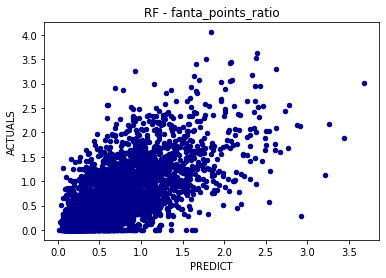

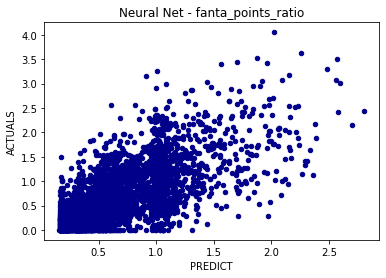

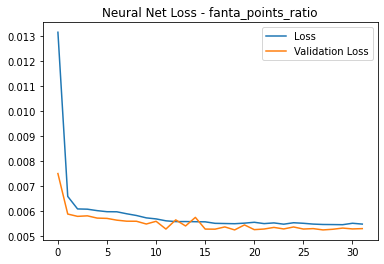

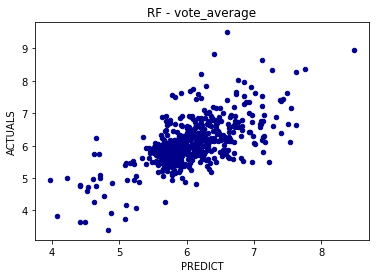

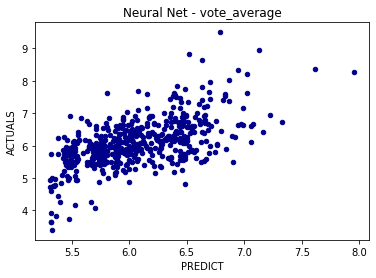

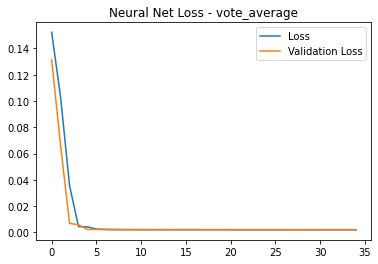

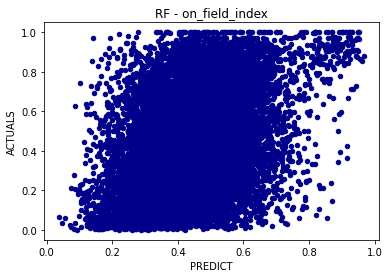

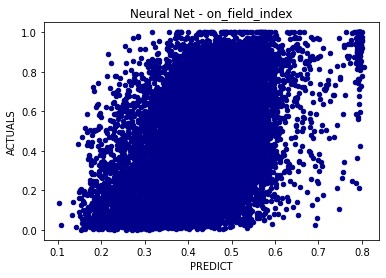

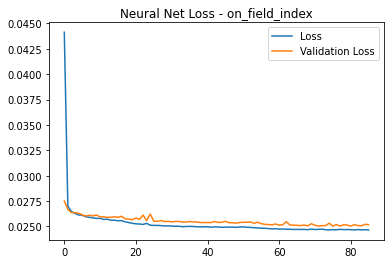

In [93]:
bonus = params["FEATURES"]["FANTA_POINTS_RATIO"]
on_field = params["FEATURES"]["ON_FIELD_INDEX"]
vote = params["FEATURES"]["AVG_VOTE"]

dataset_bonus = train_predict(params, complete_dataset, bonus, False)

dataset_vote = train_predict(params, complete_dataset, vote, True)

dataset_on_field = train_predict(params, complete_dataset, on_field, True)

In [95]:
dataset_bonus[[f"{bonus}_APE_NN", f"{bonus}_APE_RF", f"{bonus}_APE_ANS"]].mean()

TypeError: tuple indices must be integers or slices, not list

In [ ]:
dataset_on_field[[f"{on_field}_APE_NN", f"{on_field}_APE_RF", f"{on_field}_APE_ANS"]].mean()

on_field_index_APE_NN     1.314069
on_field_index_APE_RF     0.847021
on_field_index_APE_ANS    1.073877
dtype: float64

In [ ]:
dataset_vote[[f"{vote}_APE_NN", f"{vote}_APE_RF", f"{vote}_APE_ANS"]].mean()

vote_average_APE_NN     0.072328
vote_average_APE_RF     0.041402
vote_average_APE_ANS    0.054487
dtype: float64

In [ ]:
def print_top_players(df, y_feature, competition_id="IT1", head=10):
    df_c = df.loc[df["competition_id"] == competition_id]
    df_c = df_c.sort_values(by=[f"{y_feature}_PRED_NN"], ascending=False).head(
        head
    )
    df_c = df_c[
        [
            "pretty_name",
            "club_pretty_name",
            "goals",
            "assists",
            y_feature,
            "played_matches",
            f"{y_feature}_PRED_NN",
            f"{y_feature}_PRED_RF",
            f"{y_feature}_PRED_ANS",
        ]
    ]

    return df_c


<AxesSubplot:>

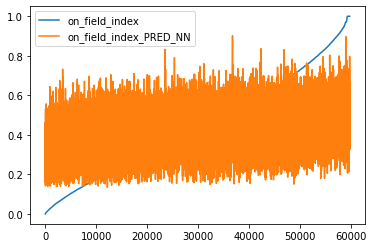

In [ ]:
dataset_on_field.sort_values(by=on_field, ignore_index=True)[[on_field, f"{on_field}_PRED_NN"]].plot()

<AxesSubplot:>

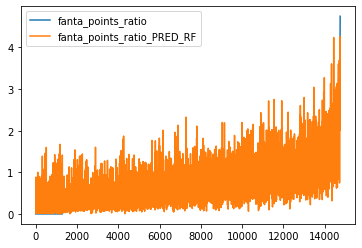

In [ ]:
dataset_bonus.sort_values(by=bonus, ignore_index=True)[[bonus, f"{bonus}_PRED_RF"]].plot()

<AxesSubplot:>

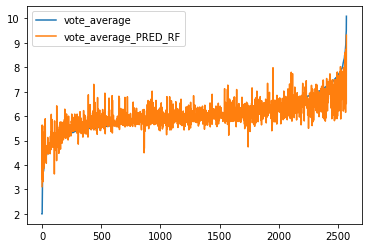

In [ ]:
# f"{y_feature}_PRED_NN",
# f"{y_feature}_PRED_RF",
# f"{y_feature}_PRED_ANS",

dataset_vote.sort_values(by=vote, ignore_index=True)[[vote, f"{vote}_PRED_RF"]].plot()

In [ ]:
print_top_players(dataset_vote, vote)

,pretty_name,club_pretty_name,goals,assists,vote_average,played_matches,vote_average_PRED_NN,vote_average_PRED_RF,vote_average_PRED_ANS
45387,Gonzalo Higuain,Juventus Turin,16,3,7.34,34,7.799615,7.733000,7.766307
45383,Gonzalo Higuain,Juventus Turin,24,3,8.26,38,7.742732,7.778600,7.760666
45543,Cristiano Ronaldo,Juventus Turin,21,8,8.79,31,7.738563,8.359600,8.049082
45261,Paulo Dybala,Juventus Turin,5,2,6.8,27,7.587102,7.453100,7.520101
40973,Mauro Icardi,Inter Mailand,11,4,6.98,29,7.548064,7.281200,7.414632
45259,Paulo Dybala,Juventus Turin,22,5,8.36,33,7.474638,7.850300,7.662469
45546,Cristiano Ronaldo,Juventus Turin,31,6,9.39,33,7.441503,8.741600,8.091552
45548,Cristiano Ronaldo,Juventus Turin,29,2,8.71,33,7.371029,8.337100,7.854065
45255,Paulo Dybala,Juventus Turin,11,7,7.91,29,7.315264,7.872700,7.593982
45187,Alvaro Morata,Juventus Turin,7,7,6.96,28,7.292558,7.307267,7.299912


In [ ]:
print_top_players(dataset_bonus, bonus)

,pretty_name,club_pretty_name,goals,assists,fanta_points_ratio,played_matches,fanta_points_ratio_PRED_NN,fanta_points_ratio_PRED_RF,fanta_points_ratio_PRED_ANS
45543,Cristiano Ronaldo,Juventus Turin,21,8,2.376348,31,2.781423,2.596576,2.689000
45387,Gonzalo Higuain,Juventus Turin,16,3,1.628815,34,2.764835,3.045733,2.905284
45383,Gonzalo Higuain,Juventus Turin,24,3,2.275025,38,2.685311,2.560245,2.622778
40973,Mauro Icardi,Inter Mailand,11,4,1.467607,29,2.651434,2.797934,2.724684
45261,Paulo Dybala,Juventus Turin,5,2,0.715957,27,2.489547,1.549687,2.019617
45546,Cristiano Ronaldo,Juventus Turin,31,6,3.052415,33,2.353462,2.468933,2.411198
45259,Paulo Dybala,Juventus Turin,22,5,2.712224,33,2.310937,1.762729,2.036833
45548,Cristiano Ronaldo,Juventus Turin,29,2,2.857653,33,2.225307,1.940509,2.082908
10875,Gonzalo Higuain,Ssc Neapel,18,7,1.97482,37,2.180310,2.023812,2.102061
45255,Paulo Dybala,Juventus Turin,11,7,1.672085,29,2.179156,1.837766,2.008461


In [ ]:
print_top_players(dataset_on_field, on_field)

,pretty_name,club_pretty_name,goals,assists,on_field_index,played_matches,on_field_index_PRED_NN,on_field_index_PRED_RF,on_field_index_PRED_ANS
211,Sergej Milinković Savić,Lazio Rom,5,3,0.703216,31,0.710274,0.626854,0.668564
10989,Kalidou Koulibaly,Ssc Neapel,2,1,0.916667,35,0.700649,0.821744,0.761197
45321,Matthijs De Ligt,Juventus Turin,3,0,0.772222,<NA>,0.674433,0.745912,0.710172
42952,Mattia Perin,Genua Cfc,0,0,0.657895,25,0.673599,0.607728,0.640664
48994,Leonardo Bonucci,Ac Mailand,2,0,0.902047,35,0.672734,0.791700,0.732217
40973,Mauro Icardi,Inter Mailand,11,4,0.66345,29,0.672687,0.620062,0.646374
48933,Gianluigi Donnarumma,Ac Mailand,0,0,0.95,37,0.670450,0.807701,0.739075
45543,Cristiano Ronaldo,Juventus Turin,21,8,0.786257,31,0.670107,0.558889,0.614498
48930,Gianluigi Donnarumma,Ac Mailand,0,0,0.904094,34,0.661070,0.888775,0.774922
42954,Mattia Perin,Genua Cfc,0,0,0.973684,37,0.660895,0.772320,0.716608
